
# Finance project *2*



In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.sparse
import scipy.sparse.linalg
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import scipy.sparse.linalg as spla
from scipy.sparse import csr_matrix
from time import process_time
import scipy.integrate as integrate
import scipy.special as special


Option trading reached a volume of billions of dollars every year and,
consequently, option pricing now plays a central role in modern finance. Fast
and accurate methods for option pricing became of paramount importance,
especially in the case of basket options (higher space dimensions).
This small computational project has the objective of implementing and
comparing two classical methods for option pricing: i. The numerical solution
of the Black-Scholes partial differential equation and ii. The binomial
methods.

# Exact solution for European options

In [70]:
def d1(S,K,r,s,T,t):
  return (np.log(S/K)+(r+s**2/2)*(T-t))/(s*np.sqrt(T-t))

def d2(S,K,r,s,T,t):
  return (np.log(S/K)+(r-s**2/2)*(T-t))/(s*np.sqrt(T-t))

def Nfunc(d):
  return (integrate.quad(lambda x: np.exp(-x**2/2), -np.inf, d)/np.sqrt(2*np.pi))[0] #integrate.quad returns also the error in the second component

def exact_eur(S, t, T, E, r, sig, opt_type):
  if opt_type == 0:
    return round(-S*Nfunc( -d1(S,E,r,sig,T,t) ) + E*np.exp(-r*(T-t))*Nfunc(-d2(S,E,r,sig,T,t)) , 7)
  else:
    return round(S*Nfunc( d1(S,E,r,sig,T,t) ) - E*np.exp(-r*(T-t))*Nfunc(d2(S,E,r,sig,T,t)) , 7)

# 1a) Explicit


Considering
$$\frac{\partial V}{\partial t}(S,t)+\frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial t^2}+rS\frac{\partial V}{\partial S}-rV=0$$
and its finite difference approximation at $(S,t)=(n \cdot ds,(m-j) \cdot dt)$
$$\frac{V^{m-j}_n-V^{m-j-1}_n}{dt}\approx -\frac{1}{2}\sigma^2S_n^2\frac{V^{m-j}_{n+1}-2V^{m-j}_n+V^{m-j}_{n-1}}{ds^2}-rS_n\frac{V^{m-1}_{n+1}-V^{m-1}_{n-1}}{2ds}-rV^{m-j}_n,$$
we can resolve for $V^{m-j-1}_n$ obtaining the coefficients of the matrix $A$ (see the code). 

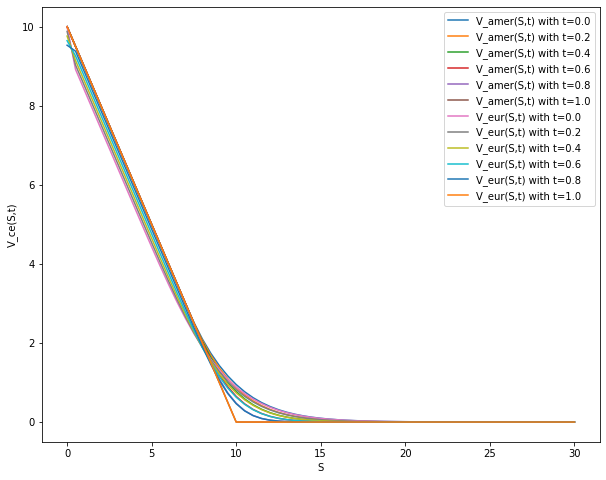

In [71]:
### EXPLICIT METHOD ###

opt_type = 0   #type of the option (0 -> put, 1 -> call)

E = 10         #strike price
r = 0.06        #risk free interest rate
sig = 0.3       #volatitily (sigma in the sheet)
T = 1           #expiration time

Smin = 0
Smax = 30      # range of S we whant to consider 

#domain discretization
dt = 0.0001
ds = 0.5


# grid with N*m points, where
N = int((Smax - Smin)/ds)
m = int(T/dt)


def d1(S,K,r,s,T,t):
  return (np.log(S/K)+(r+s**2/2)*(T-t))/(s*np.sqrt(T-t))

def d2(S,K,r,s,T,t):
  return (np.log(S/K)+(r-s**2/2)*(T-t))/(s*np.sqrt(T-t))

def Nfunc(d):
  return (integrate.quad(lambda x: np.exp(-x**2/2), -np.inf, d)/np.sqrt(2*np.pi))[0] #integrate.quad returns also the error in the second component

def S(Smin,n):
  return (Smin + n*ds)

def pay_off(opt_type, s, E):
  if opt_type == 0:  
    return max(E-s, 0)
  elif opt_type == 1:
    return max(s-E,0)

##############################################################################################################################################################################

# Explicit method for european options

def expl_eur(Smin, Smax ,r ,sig, dt, T, N, m, ds, opt_type):

  V_e = np.zeros((N+1,m+1)) #V_e(t,S) value of the european option

  # initial condition 
  for n in range(0,N+1):
    V_e[n,m] = pay_off(opt_type, S(Smin,n), E)

  # matrix A
  A = np.zeros((N+1,N+1))
  for n in range(0,N+1):
    if n == 0 or n == N:
      A[n,n] = 1
    else:
      A[n,n-1] = 0.5*dt/ds*(sig**2*(S(Smin,n))**2/ds - S(Smin,n)*r)
      A[n,n] = 1 - dt*( r+ (sig*S(Smin,n)/ds)**2 )
      A[n,n+1] = 0.5*dt/ds*(sig**2*(S(Smin,n))**2/ds + S(Smin,n)*r)

  # sparse version of A
  A_csr = csr_matrix(A)

  # remark: we are going back in time
  for j in range(0, m):
    for n in range(1,N):
       V_e[n,m-j-1] =  A[n,n-1]*V_e[n-1,m-j] +  A[n,n]*V_e[n,m-j] +  A[n,n+1]*V_e[n+1,m-j]
    # boundary condition at S = Smax
    if opt_type == 1:
      V_e[N,m-j-1] = Smax - E*np.exp(-r*(T-(m-j-1)*dt)) 
    if opt_type == 0:
      V_e[N,m-j-1] = 0
    # boundary condition at S = Smin 
    # if Smin = 0
    if Smin == 0 and opt_type == 1:
      V_e[0, m-j-1] = 0
    if Smin == 0 and opt_type == 0:
      V_e[0, m-j-1] = E*np.exp(-r*(m-j-1)*dt)
    # if Smin != 0
    if Smin != 0 and opt_type == 1:
      t = (m-j-1)*dt
      V_e[0, m-j-1] = Smin*Nfunc( d1(Smin,E,r,sig,T,t) ) - E*np.exp(-r*(T-t))*Nfunc(d2(Smin,E,r,sig,T,t))  #i.e. we use the exact formula
    if Smin != 0 and opt_type == 0:
      t = (m-j-1)*dt
      V_e[0, m-j-1] = -Smin*Nfunc( -d1(Smin,E,r,sig,T,t) ) + E*np.exp(-r*(T-t))*Nfunc(-d2(Smin,E,r,sig,T,t))  #i.e. we use the exact formula

  return V_e

##############################################################################################################################################################################

# Explicit method for american options

def expl_amer(Smin, Smax ,r ,sig, dt, T, N, m, ds, opt_type):

  V_e = np.zeros((N+1,m+1)) #V_e(t,S) value of the european option

  # initial condition 
  for n in range(0,N+1):
    V_e[n,m] = pay_off(opt_type, S(Smin,n), E)

  # matrix A
  A = np.zeros((N+1,N+1))
  for n in range(0,N+1):
    if n == 0 or n == N:
      A[n,n] = 1
    else:
      A[n,n-1] = 0.5*dt/ds*(sig**2*(S(Smin,n))**2/ds - S(Smin,n)*r)
      A[n,n] = 1 - dt*( r+ (sig*S(Smin,n)/ds)**2 )
      A[n,n+1] = 0.5*dt/ds*(sig**2*(S(Smin,n))**2/ds + S(Smin,n)*r)

  # sparse version of A
  A_csr = csr_matrix(A)

  # remark: we are going back in time
  for j in range(0, m):
    for n in range(1,N):
       V_e[n,m-j-1] =  A[n,n-1]*V_e[n-1,m-j] +  A[n,n]*V_e[n,m-j] +  A[n,n+1]*V_e[n+1,m-j]   
    # boundary condition at S = Smax
    if opt_type == 1:
      V_e[N,m-j-1] = Smax - E*np.exp(-r*(T-(m-j-1)*dt)) 
    if opt_type == 0:
      V_e[N,m-j-1] = 0
    # boundary condition at S = Smin 
    # if Smin = 0
    if Smin == 0 and opt_type == 1:
      V_e[0, m-j-1] = 0
    if Smin == 0 and opt_type == 0:
      V_e[0, m-j-1] = E*np.exp(-r*(m-j-1)*dt)
    # if Smin != 0
    if Smin != 0 and opt_type == 1:
      t = (m-j-1)*dt
      V_e[0, m-j-1] = Smin*Nfunc( d1(Smin,E,r,sig,T,t) ) - E*np.exp(-r*(T-t))*Nfunc(d2(Smin,E,r,sig,T,t)) #i.e. we use the exact formula
    if Smin != 0 and opt_type == 0:
      t = (m-j-1)*dt
      V_e[0, m-j-1] = -Smin*Nfunc( -d1(Smin,E,r,sig,T,t) ) + E*np.exp(-r*(T-t))*Nfunc(-d2(Smin,E,r,sig,T,t)) #i.e. we use the exact formula
    # Check the >= payoff constraint
    for n in range(0,N):
      V_e[n,m-j-1] = max(V_e[n,m-j-1] , pay_off(opt_type, S(Smin,n), E))

  return V_e

##############################################################################################################################################################################



# plot the graph of the approximated function
s = np.linspace(Smin, Smax, N+1)

plt.figure(figsize=(10,8))

L = 5 #number of curves to display + 1

V = expl_amer(Smin, Smax ,r ,sig, dt, T, N, m, ds, opt_type)

W = expl_eur(Smin, Smax ,r ,sig, dt, T, N, m, ds, opt_type)

for i in range(0,L+1):
  k = int(m/L*i)
  t = round(k*dt,3)
  plt.plot(s, V[:,k], label='V_amer(S,t) with t=' + str(t))

for i in range(0,L+1):
  k = int(m/L*i)
  t = round(k*dt,3)
  plt.plot(s, W[:,k], label='V_eur(S,t) with t=' + str(t))
#k = int(M)
#t = round(k*dt,3)
#print(V_ce[:,k])
#plt.plot(s, V_ce[:,k], label='V(S,t) with t=' + str(t))
plt.xlabel('S')
plt.ylabel('V_ce(S,t)')
plt.legend()
plt.show()



# 1b) Implicit


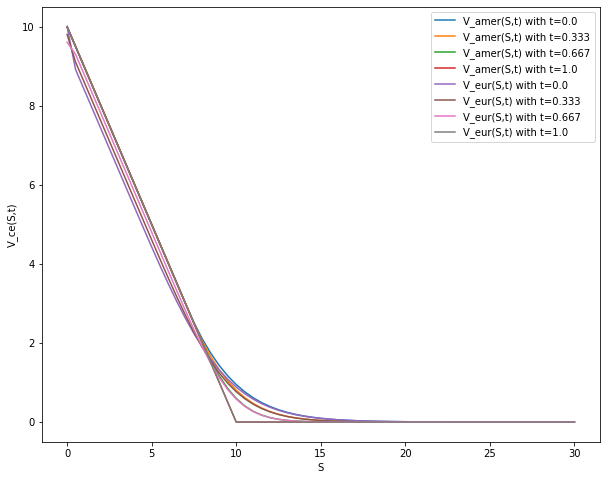

In [72]:
### IMPLICIT METHOD ###

opt_type = 0   #type of the option (0 -> put, 1 -> call)

E = 10         #strike price
r = 0.06        #risk free interest rate
sig = 0.3       #volatitily (sigma in the sheet)
T = 1           #expiration time

Smin = 0
Smax = 30      # range of S we whant to consider 

S0 = 9

#domain discretization
dt = 0.0001
ds = 0.5


# grid with N*m points, where
N = int((Smax - Smin)/ds)
m = int(T/dt)


def d1(S,K,r,s,T,t):
  return (np.log(S/K)+(r+s**2/2)*(T-t))/(s*np.sqrt(T-t))

def d2(S,K,r,s,T,t):
  return (np.log(S/K)+(r-s**2/2)*(T-t))/(s*np.sqrt(T-t))

def Nfunc(d):
  return (integrate.quad(lambda x: np.exp(-x**2/2), -np.inf, d)/np.sqrt(2*np.pi))[0] #integrate.quad returns also the error in the second component

def S(Smin,n):
  return (Smin + n*ds)

def pay_off(opt_type, s, E):
  if opt_type == 0:  
    return max(E-s, 0)
  elif opt_type == 1:
    return max(s-E,0)

##############################################################################################################################################################################

# Implicit method for european options

def impl_eur(Smin, Smax ,r ,sig, dt, T, N, m, ds, opt_type):

  V_e = np.zeros((N+1,m+1)) #V_e(t,S) value of the european option

  # initial condition 
  for n in range(0,N+1):
    V_e[n,m] = pay_off(opt_type, S(Smin,n), E)

  # matrix A
  A = np.zeros((N+1,N+1))
  for n in range(0,N+1):
    if n == 0 or n == N:
      A[n,n] = 1
    else:
      A[n,n-1] = -0.5*dt/ds*(sig**2*(S(Smin,n))**2/ds - S(Smin,n)*r)
      A[n,n] = 1 + dt*(r+ (sig*S(Smin,n)/ds)**2 )
      A[n,n+1] = -0.5*dt/ds*(sig**2*(S(Smin,n))**2/ds + S(Smin,n)*r)

  # sparse version of A
  A_csr = csr_matrix(A)

  # remark: we are going back in time
  for j in range(0, m):
    #V_e[:,m-j-1] = np.linalg.solve(A, V_e[:,M-j])  
    #we can use a sparse matrix to solve faster
    V_e[:,m-j-1] = spla.dsolve.spsolve(A_csr, V_e[:,m-j])
    # boundary condition at S = Smax
    if opt_type == 1:
      V_e[N,m-j-1] = Smax - E*np.exp(-r*(T-(m-j-1)*dt)) 
    if opt_type == 0:
      V_e[N,m-j-1] = 0
    # boundary condition at S = Smin 
    # if Smin = 0
    if Smin == 0 and opt_type == 1:
      V_e[0, m-j-1] = 0
    if Smin == 0 and opt_type == 0:
      V_e[0, m-j-1] = E*np.exp(-r*(m-j-1)*dt)
    # if Smin != 0
    if Smin != 0 and opt_type == 1:
      t = (m-j-1)*dt
      V_e[0, m-j-1] = round(Smin*Nfunc( d1(Smin,E,r,sig,T,t) ) - E*np.exp(-r*(T-t))*Nfunc(d2(Smin,E,r,sig,T,t)) , 3) #i.e. we use the exact formula
    if Smin != 0 and opt_type == 0:
      t = (m-j-1)*dt
      V_e[0, m-j-1] = round(-Smin*Nfunc( -d1(Smin,E,r,sig,T,t) ) + E*np.exp(-r*(T-t))*Nfunc(-d2(Smin,E,r,sig,T,t)) , 3) #i.e. we use the exact formula

  return V_e

##############################################################################################################################################################################

# Implicit method for american options

def impl_amer(Smin, Smax ,r ,sig, dt, T, N, m, ds, opt_type):

  V_e = np.zeros((N+1,m+1)) #V_e(t,S) value of the european option

  # initial condition 
  for n in range(0,N+1):
    V_e[n,m] = pay_off(opt_type, S(Smin,n), E)

  # matrix A
  A = np.zeros((N+1,N+1))
  for n in range(0,N+1):
    if n == 0 or n == N:
      A[n,n] = 1
    else:
      A[n,n-1] = -0.5*dt/ds*(sig**2*(S(Smin,n))**2/ds - S(Smin,n)*r)
      A[n,n] = 1 + dt*(r+ (sig*S(Smin,n)/ds)**2 )
      A[n,n+1] = -0.5*dt/ds*(sig**2*(S(Smin,n))**2/ds + S(Smin,n)*r)

  # sparse version of A
  A_csr = csr_matrix(A)

  # remark: we are going back in time
  for j in range(0, m):
    #V_e[:,m-j-1] = np.linalg.solve(A, V_e[:,M-j])  
    #we can use a sparse matrix to solve faster
    V_e[:,m-j-1] = spla.dsolve.spsolve(A_csr, V_e[:,m-j])   
    # boundary condition at S = Smax
    if opt_type == 1:
      V_e[N,m-j-1] = Smax - E*np.exp(-r*(T-(m-j-1)*dt)) 
    if opt_type == 0:
      V_e[N,m-j-1] = 0
    # boundary condition at S = Smin 
    # if Smin = 0
    if Smin == 0 and opt_type == 1:
      V_e[0, m-j-1] = 0
    if Smin == 0 and opt_type == 0:
      V_e[0, m-j-1] = E*np.exp(-r*(m-j-1)*dt)
    # if Smin != 0
    if Smin != 0 and opt_type == 1:
      t = (m-j-1)*dt
      V_e[0, m-j-1] = round(Smin*Nfunc( d1(Smin,E,r,sig,T,t) ) - E*np.exp(-r*(T-t))*Nfunc(d2(Smin,E,r,sig,T,t)) , 3) #i.e. we use the exact formula
    if Smin != 0 and opt_type == 0:
      t = (m-j-1)*dt
      V_e[0, m-j-1] = round(-Smin*Nfunc( -d1(Smin,E,r,sig,T,t) ) + E*np.exp(-r*(T-t))*Nfunc(-d2(Smin,E,r,sig,T,t)) , 3) #i.e. we use the exact formula
    # Check the >= payoff constraint
    for n in range(0,N):
      V_e[n,m-j-1] = max(V_e[n,m-j-1] , pay_off(opt_type, S(Smin,n), E))

  return V_e

##############################################################################################################################################################################




# plot the graph of the approximated function
s = np.linspace(Smin, Smax, N+1)

plt.figure(figsize=(10,8))

L = 3 #number of curves to display + 1

V = impl_amer(Smin, Smax ,r ,sig, dt, T, N, m, ds, opt_type)

W = impl_eur(Smin, Smax ,r ,sig, dt, T, N, m, ds, opt_type)

for i in range(0,L+1):
  k = int(m/L*i)
  t = round(k*dt,3)
  plt.plot(s, V[:,k], label='V_amer(S,t) with t=' + str(t))

for i in range(0,L+1):
  k = int(m/L*i)
  t = round(k*dt,3)
  plt.plot(s, W[:,k], label='V_eur(S,t) with t=' + str(t))
#k = int(M)
#t = round(k*dt,3)
#print(V_ce[:,k])
#plt.plot(s, V_ce[:,k], label='V(S,t) with t=' + str(t))
plt.xlabel('S')
plt.ylabel('V_ce(S,t)')
plt.legend()
plt.show()




# 2) Binomial


Implement the binomial method for both European and American call
and put options, using at least two different parameter choices (for
instance $p = 1/2$ or $u=1/d$).

In [62]:
# Binomial algorithm for european option having linear space complexity
# and quadratic time complexity (respect to M)

opt_type = 0    #type of the option (0 -> put, 1 -> call)

case = 0    #case = 0 -> u=1/d
            #case = 1 -> p=1/2

E = 10         #strike price
r = 0.06        #risk free interest rate
sig = 0.3       #volatitily (sigma in the sheet)
M = 256          #expiration time
T = 1
dt = T/M

S0 = 9        # current price of the underlying

def pay_off(opt_type, s, E):
  if opt_type == 0:  
    return max(E-s, 0)
  elif opt_type == 1:
    return max(s-E,0)

def u(case,r,dt,sig):
  if case == 0:
    A = 0.5*(np.exp(-r*dt)+np.exp((r+sig**2)*dt))
    return A + (A**2 - 1)**(0.5)
  else: 
    return np.exp(r*dt)*(1 + (np.exp(sig**2*dt)-1)**(0.5))

def d(case,r,dt,sig):     
  if case == 0:
    A = 0.5*(np.exp(-r*dt)+np.exp((r+sig**2)*dt))
    return A - (A**2 - 1)**(0.5)
  else:
    return np.exp(r*dt)*(1 - (np.exp(sig**2*dt)-1)**(0.5))

def p(case,r,dt,sig):
  if case == 0:
    return (np.exp(r*dt)-d(case,r,dt,sig))/(u(case,r,dt,sig)-d(case,r,dt,sig))
  else:
    return 0.5

def bin_eur(S0,u,d,p,r,dt,M,E,opt_type):
  discount = np.exp(-r*dt)
  list = np.zeros(M+1)
  list[0] = S0
  for m in range(1,M+1):
    for n in range(m, 0,-1):
      list[n] = u*list[n-1]
    list[0] = d*list[0]

  for n in range(0,M+1):
    list[n] = pay_off(opt_type, list[n], E)
    
  for m in range(M,0,-1):
    for n in range(0,m):
      temp = p*list[n+1] + (1-p)*list[n]
      list[n] = discount*temp

  return list[0]

#print(bin_eur(S0,u(case,r,dt,sig),d(case,r,dt,sig),p(case,r,dt,sig),r,dt,M,E,opt_type))

#-----------------------------------------------------------------------------#

# Binomial algorithm for american option having both space and 
#time complexity quadratic (respect to M)

def bin_amer(S0,u,d,p,r,dt,M,E,opt_type):
  discount = np.exp(-r*dt)
  S = np.zeros((M+2,M+2))    # underling's prices
  V = np.zeros((M+2,M+2))    # option's values
  S[0][0] = S0  

  for m in range(1,M+1):
    for n in range(m+1,0, -1):
        S[m][n] = u*S[m-1][n-1]
    S[m][0] = d*S[m-1][0]

  for n in range(0,M+1):
    V[M][n] = pay_off(opt_type, S[M][n], E)
  
  for m in range(M,-1,-1):
    for n in range(0,m+1):
      hold = (1-p)*V[m+1][n] + p*V[m+1][n+1]
      hold = hold * discount
      V[m][n] = max(hold, pay_off(opt_type, S[m][n], E) )
  #print(S)
  #print(V)
  return V[0][0]




# 3&4)


Choose a base parameter set (risk-free interest rate, volatility, Strike
price, spot price and maturity) and i. using the Black-Scholes equations,
price the option with an accuracy of three decimal places; ii.
obtain comparable results using the binomial method.

Conduct the tests you see fit, in order to compare the methods in terms
of computational complexity for a fixed accuracy.
*****************************************************************************************************************************************

Below we present 3 different choices of mesh that provides approximate solution with respectively 2, 3 and 4 decimal cifres of accurrency. 
For each method and case we also plot the time elasped in the computation.
***********************************************************
Note: The values for the mesh are quite arbitrary. To be more rigorous, one could write a function that calculate the solution with a fixed method and at each step refines the mesh untill gets the wanted accurrency. However, this method is quite time expansive and my computer is old :/

- Here we plot solutions with accurrency of 2 decimal cifres.

In [97]:
opt_type = 0    #type of the option (0 -> put, 1 -> call)
E = 10         #strike price
r = 0.06        #risk free interest rate
sig = 0.3       #volatitily (sigma in the sheet)
T = 1           # expiration time

S0 = 9        # current price of the underlying  

#------------------------------------------------------------------------------#

# time discretization for binomial model
M = 128
dt = T/M

# case to consider in the binomial model
case = 0    #case = 0 -> u=1/d   #case = 1 -> p=1/2

#------------------------------------------------------------------------------#

# range of S we whant to consider for the Black-Sholes model
Smin = 0
Smax = 50

#domain discretization explicit model
dT = 0.0001
ds = 0.5
N = int((Smax - Smin)/ds)
m = int(T/dT)

################################################################################


t1 = process_time()
W = expl_eur(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t2 = process_time()
H = impl_eur(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t3 = process_time()
bineur = round(bin_eur(S0,u(case,r,dt,sig),d(case,r,dt,sig),p(case,r,dt,sig),r,dt,M,E,opt_type),6)
t4 = process_time()
V = expl_amer(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t5 = process_time()
K = impl_amer(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t6 = process_time()
binamer = round(bin_amer(S0,u(case,r,dt,sig),d(case,r,dt,sig),p(case,r,dt,sig),r,dt,M,E,opt_type),6)
t7 = process_time()

x = int(S0/ds)

print("European option value computed using exact formula")
print(round(exact_eur(S0, 0, T, E, r, sig, opt_type),6))
print("")
print("Using the above mesh choice:")
print("----------------------------------------------------------------------------")
print("European option value computed using explicit method in seconds:", round(t2-t1,5))
print(round(W[x,0],6))
print("")
print("European option value computed using implicit method in seconds:", round(t3-t2,5))
print(round(H[x,0],6))
print("")
print("European option value computed using binomial method in seconds:", round(t4-t3,5))
print(bineur)
print("")
print("American option value computed using explicit method in seconds:", round(t5-t4,5))
print(round(V[x,0],6))
print("")
print("American option value computed using implicit method in seconds:", round(t6-t5,5))
print(round(K[x,0],6))
print("")
print("American option value computed using binomial method in seconds:", round(t7-t6,5))
print(binamer)
print("---------------------------------------------------------------------------")

European option value computed using exact formula
1.319271

Using the above mesh choice:
----------------------------------------------------------------------------
European option value computed using explicit method in seconds: 1.96024
1.315377

European option value computed using implicit method in seconds: 0.92245
1.315357

European option value computed using binomial method in seconds: 0.00841
1.317701

American option value computed using explicit method in seconds: 2.96872
1.42938

American option value computed using implicit method in seconds: 2.27729
1.429329

American option value computed using binomial method in seconds: 0.0267
1.434159
---------------------------------------------------------------------------


- Here we plot solutions with accurrency of 3 decimal cifres ($≈2$ minutes to compile).

In [99]:
opt_type = 0    #type of the option (0 -> put, 1 -> call)
E = 10         #strike price
r = 0.06        #risk free interest rate
sig = 0.3       #volatitily (sigma in the sheet)
T = 1           # expiration time

S0 = 9        # current price of the underlying  

#------------------------------------------------------------------------------#

# time discretization for binomial model
M = 500
dt = T/M

# case to consider in the binomial model
case = 0    #case = 0 -> u=1/d   #case = 1 -> p=1/2

#------------------------------------------------------------------------------#

# range of S we whant to consider for the Black-Sholes model
Smin = 0
Smax = 50

#domain discretization explicit model
dT = 0.000025
ds = 0.125
N = int((Smax - Smin)/ds)
m = int(T/dT)

################################################################################


t1 = process_time()
W = expl_eur(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t2 = process_time()
H = impl_eur(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t3 = process_time()
bineur = round(bin_eur(S0,u(case,r,dt,sig),d(case,r,dt,sig),p(case,r,dt,sig),r,dt,M,E,opt_type),6)
t4 = process_time()
V = expl_amer(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t5 = process_time()
K = impl_amer(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t6 = process_time()
binamer = round(bin_amer(S0,u(case,r,dt,sig),d(case,r,dt,sig),p(case,r,dt,sig),r,dt,M,E,opt_type),6)
t7 = process_time()

x = int(S0/ds)

print("European option value computed using exact formula")
print(round(exact_eur(S0, 0, T, E, r, sig, opt_type),6))
print("")
print("Using the above mesh choice:")
print("----------------------------------------------------------------------------")
print("European option value computed using explicit method in seconds:", round(t2-t1,5))
print(round(W[x,0],6))
print("")
print("European option value computed using implicit method in seconds:", round(t3-t2,5))
print(round(H[x,0],6))
print("")
print("European option value computed using binomial method in seconds:", round(t4-t3,5))
print(bineur)
print("")
print("American option value computed using explicit method in seconds:", round(t5-t4,5))
print(round(V[x,0],6))
print("")
print("American option value computed using implicit method in seconds:", round(t6-t5,5))
print(round(K[x,0],6))
print("")
print("American option value computed using binomial method in seconds:", round(t7-t6,5))
print(binamer)
print("---------------------------------------------------------------------------")

European option value computed using exact formula
1.319271

Using the above mesh choice:
----------------------------------------------------------------------------
European option value computed using explicit method in seconds: 26.24924
1.319031

European option value computed using implicit method in seconds: 9.45868
1.319026

European option value computed using binomial method in seconds: 0.13132
1.319104

American option value computed using explicit method in seconds: 51.62008
1.434202

American option value computed using implicit method in seconds: 33.50705
1.434188

American option value computed using binomial method in seconds: 0.42943
1.434532
---------------------------------------------------------------------------


- Here we plot solutions with accurrency of 4 decimal cifres.
- Remark: this cell is quite time expansive to compile $\approx 12$ minutes

In [100]:
opt_type = 0    #type of the option (0 -> put, 1 -> call)
E = 10         #strike price
r = 0.06        #risk free interest rate
sig = 0.3       #volatitily (sigma in the sheet)
T = 1           # expiration time

S0 = 9        # current price of the underlying  

#------------------------------------------------------------------------------#

# time discretization for binomial model
M = 2000
dt = T/M

# case to consider in the binomial model
case = 0    #case = 0 -> u=1/d   #case = 1 -> p=1/2

#------------------------------------------------------------------------------#

# range of S we whant to consider for the Black-Sholes model
Smin = 0
Smax = 50

#domain discretization explicit model
dT = 0.00001
ds = 0.05
N = int((Smax - Smin)/ds)
m = int(T/dT)

################################################################################


t1 = process_time()
W = expl_eur(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t2 = process_time()
H = impl_eur(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t3 = process_time()
bineur = round(bin_eur(S0,u(case,r,dt,sig),d(case,r,dt,sig),p(case,r,dt,sig),r,dt,M,E,opt_type),6)
t4 = process_time()
V = expl_amer(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t5 = process_time()
K = impl_amer(Smin, Smax ,r ,sig, dT, T, N, m, ds, opt_type)
t6 = process_time()
binamer = round(bin_amer(S0,u(case,r,dt,sig),d(case,r,dt,sig),p(case,r,dt,sig),r,dt,M,E,opt_type),6)
t7 = process_time()

x = int(S0/ds)

print("European option value computed using exact formula")
print(round(exact_eur(S0, 0, T, E, r, sig, opt_type),6))
print("")
print("Using the above mesh choice:")
print("----------------------------------------------------------------------------")
print("European option value computed using explicit method in seconds:", round(t2-t1,5))
print(round(W[x,0],6))
print("")
print("European option value computed using implicit method in seconds:", round(t3-t2,5))
print(round(H[x,0],6))
print("")
print("European option value computed using binomial method in seconds:", round(t4-t3,5))
print(bineur)
print("")
print("American option value computed using explicit method in seconds:", round(t5-t4,5))
print(round(V[x,0],6))
print("")
print("American option value computed using implicit method in seconds:", round(t6-t5,5))
print(round(K[x,0],6))
print("")
print("American option value computed using binomial method in seconds:", round(t7-t6,5))
print(binamer)
print("---------------------------------------------------------------------------")



European option value computed using exact formula
1.319271

Using the above mesh choice:
----------------------------------------------------------------------------
European option value computed using explicit method in seconds: 171.48876
1.319232

European option value computed using implicit method in seconds: 51.74149
1.31923

European option value computed using binomial method in seconds: 2.03593
1.319291

American option value computed using explicit method in seconds: 312.40605
1.434452

American option value computed using implicit method in seconds: 190.62272
1.434446

American option value computed using binomial method in seconds: 6.51613
1.434547
---------------------------------------------------------------------------
